In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
import re
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [103]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [104]:
train_data = pd.read_csv("/content/drive/MyDrive/CS5228_Project/train_superset.csv")
test_data = pd.read_csv("/content/drive/MyDrive/CS5228_Project/test_superset.csv")

In [105]:
np.random.seed(0)
df_train, df_test = train_test_split(train_data, train_size = 0.8, test_size = 0.2, random_state = 100, shuffle = True)

In [106]:
y_train_all = train_data.pop('monthly_rent')
X_train_all = train_data
y_train = df_train.pop('monthly_rent')
X_train = df_train
y_test = df_test.pop('monthly_rent')
X_test = df_test

In [107]:
gbm = lgb.LGBMRegressor()
rfe = RFE(estimator=gbm, n_features_to_select=20)
rfe = rfe.fit(X_train, y_train)
selected_columns_20 = X_train.columns[rfe.support_]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1698
[LightGBM] [Info] Number of data points in the train set: 47581, number of used features: 40
[LightGBM] [Info] Start training from score 2593.194763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1698
[LightGBM] [Info] Number of data points in the train set: 47581, number of used features: 40
[LightGBM] [Info] Start training from score 2593.194763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

In [108]:
X_train_20 = X_train[selected_columns_20]

In [109]:
selected_columns_20

Index(['flat_type', 'floor_area_sqm', 'nearest_mrt_exist',
       'nearest_mrt_planned', 'nearest_school', 'nearest_mall',
       'mrt_within_0.5_km', 'mrt_within_1_km', 'school_within_1_km',
       'school_within_2_km', 'malls_within_1_km', 'malls_within_2_km',
       'mean_coe', 'max_coe', 'min_coe', 'last_month_mean', 'last_month_max',
       'flat_model_dbss', 'subzone_encoded', 'planning_area_encoded'],
      dtype='object')

In [110]:
X_train_20.columns.tolist()[0:10]

['flat_type',
 'floor_area_sqm',
 'nearest_mrt_exist',
 'nearest_mrt_planned',
 'nearest_school',
 'nearest_mall',
 'mrt_within_0.5_km',
 'mrt_within_1_km',
 'school_within_1_km',
 'school_within_2_km']

In [111]:
gbm = lgb.LGBMRegressor(max_depth=5, min_child_samples=30, n_estimators=200,random_state=42, reg_lambda=0.1, num_leaves = 20)
gbm.fit(X_train_20, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1614
[LightGBM] [Info] Number of data points in the train set: 47581, number of used features: 20
[LightGBM] [Info] Start training from score 2593.194763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMRegressor(max_depth=5, min_child_samples=30, n_estimators=200,
              num_leaves=20, random_state=42, reg_lambda=0.1)

In [112]:
from sklearn.metrics import r2_score
y_pred_train = gbm.predict(X_train_20)
y_pred_train= (y_pred_train / 10).round() * 10
print('The r2 of train prediction is: ', r2_score(y_train,y_pred_train))
print('The rmse of train prediction is: ', round(mean_squared_error(y_train, y_pred_train) ** 0.5, 5))
y_pred_test = gbm.predict(X_test[X_train_20.columns.tolist()], num_iteration=gbm.best_iteration_)
y_pred_test= (y_pred_test / 10).round() * 10
print('The r2 of test prediction is:', r2_score(y_test,y_pred_test) )
print('The rmse of test prediction is: ', round(mean_squared_error(y_test,y_pred_test) ** 0.5, 5))


The r2 of train prediction is:  0.5691932371654652
The rmse of train prediction is:  470.21138
The r2 of test prediction is: 0.5289586718122851
The rmse of test prediction is:  487.51655


In [113]:
gbm_cv = lgb.LGBMRegressor(max_depth=5, min_child_samples=30, n_estimators=200,random_state=42, reg_lambda=0.1, num_leaves = 20)
scores = cross_val_score(gbm, X_train_20, y_train, cv=5, scoring='r2')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 38064, number of used features: 20
[LightGBM] [Info] Start training from score 2593.148382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [114]:
scores

array([0.54008045, 0.54530029, 0.52663415, 0.51866728, 0.521518  ])

The Test and train r2 scores are 0.52 and 0.56 respectively and the cross validation scores are of similar range. Hence our model is genralising well.

In [115]:
gbm_cv = lgb.LGBMRegressor(max_depth=5, min_child_samples=30, n_estimators=200,random_state=42, reg_lambda=0.1, num_leaves = 20)
scores = cross_val_score(gbm, X_train_20, y_train, cv=5, scoring='neg_root_mean_squared_error')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 38064, number of used features: 20
[LightGBM] [Info] Start training from score 2593.148382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [116]:
scores

array([-491.49183771, -487.61669062, -490.26625828, -492.53029002,
       -491.97502288])

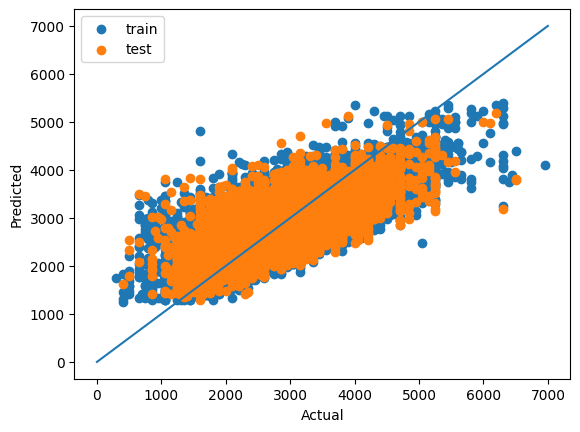

In [117]:
#Plot the scores
import matplotlib.pyplot as plt
plt.scatter(y_train, y_pred_train, label = "train")
plt.scatter(y_test, y_pred_test, label = "test")
plt.plot(list(range(7000)), list(range(7000)))
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.legend()
plt.show()

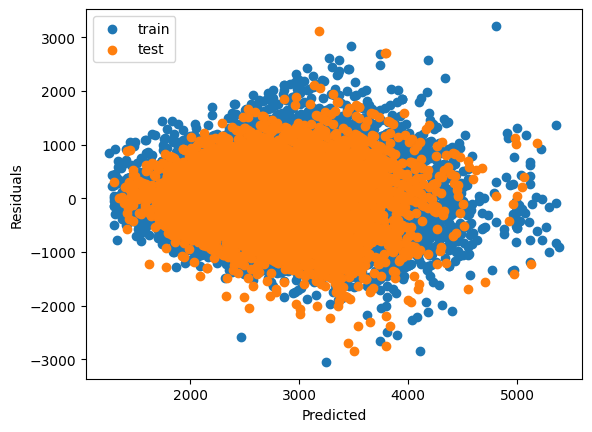

In [118]:
#Plotting the residuals
#Plot the scores
import matplotlib.pyplot as plt
#plt.scatter(list(range(len(y_train))),y_train -y_pred_train, label = "train")
plt.scatter(y_pred_train,(y_pred_train-y_train), label = "train")
plt.scatter(y_pred_test, (y_test - y_pred_test), label = "test")
plt.ylabel("Residuals")
plt.xlabel("Predicted")
plt.legend()
plt.show()

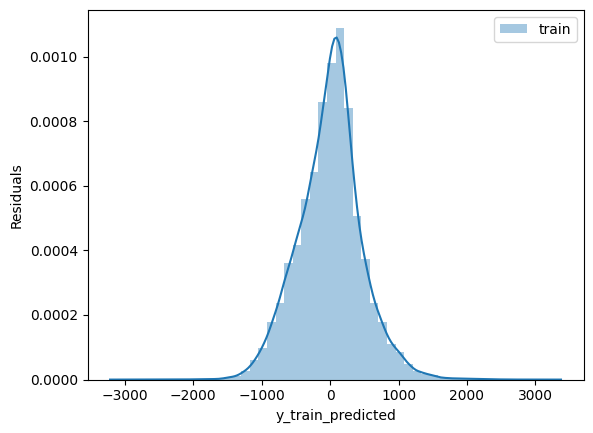

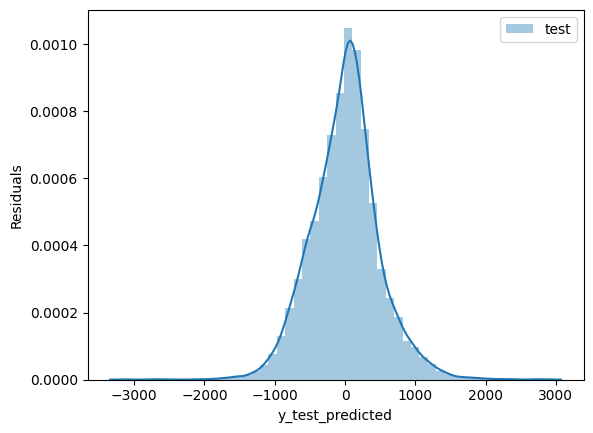

In [119]:
import seaborn as sns
sns.distplot(y_pred_train-y_train, label = "train")
plt.xlabel("y_train_predicted")
plt.ylabel("Residuals")
plt.legend()
plt.show()
sns.distplot(y_pred_test-y_test, label = "test")
plt.legend()
plt.xlabel("y_test_predicted")
plt.ylabel("Residuals")
plt.show()

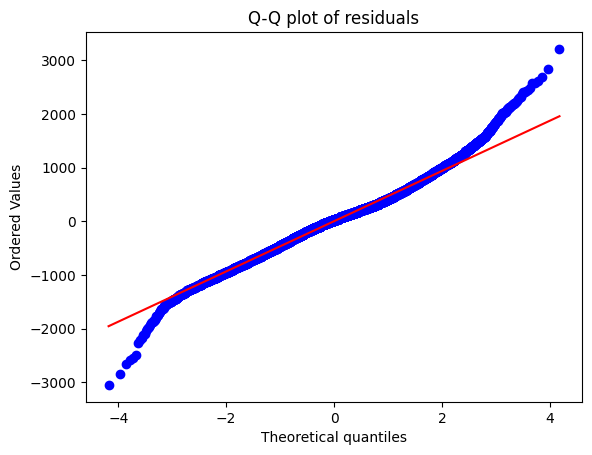

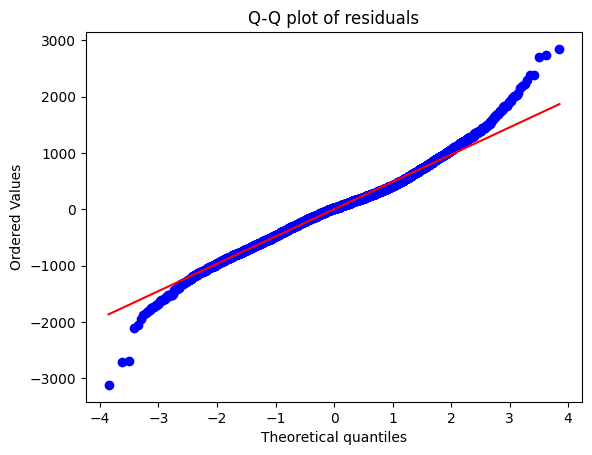

In [120]:
from scipy import stats

stats.probplot(y_pred_train-y_train, dist="norm", plot=plt)
plt.title('Q-Q plot of residuals')
plt.show()
stats.probplot(y_pred_test-y_test,dist= "norm" , plot = plt)
plt.title('Q-Q plot of residuals')
plt.show()

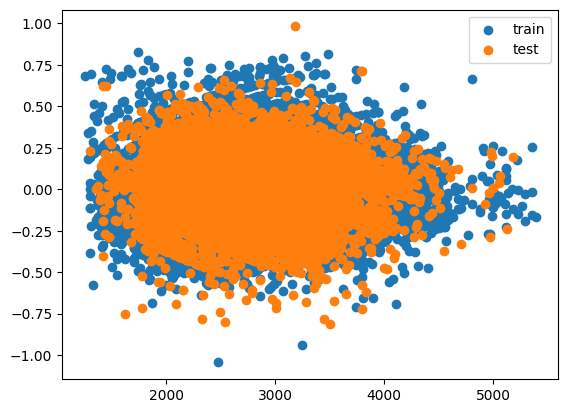

In [121]:
#Plotting the residuals
#Plot the scores
import matplotlib.pyplot as plt
#plt.scatter(list(range(len(y_train))),y_train -y_pred_train, label = "train")
plt.scatter(y_pred_train,(y_pred_train-y_train)/y_pred_train, label = "train")
plt.scatter(y_pred_test, (y_test - y_pred_test)/y_pred_test, label = "test")
plt.legend()
plt.show()

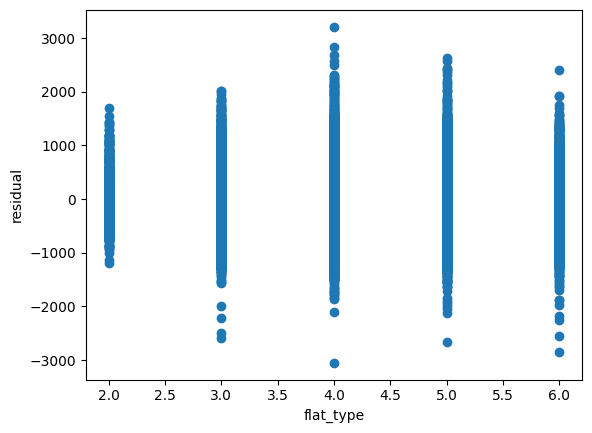

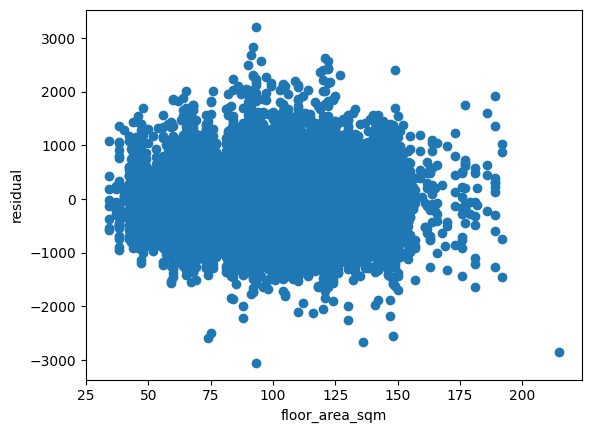

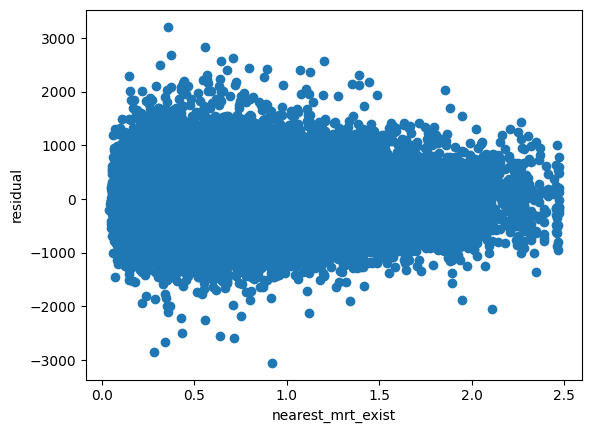

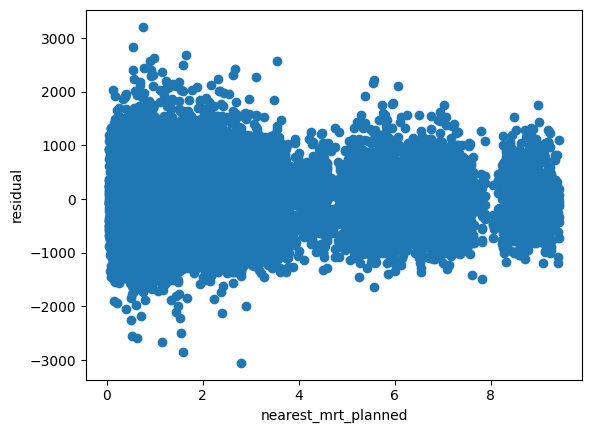

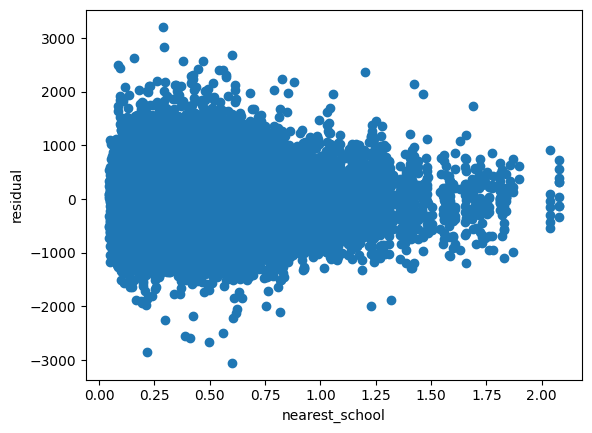

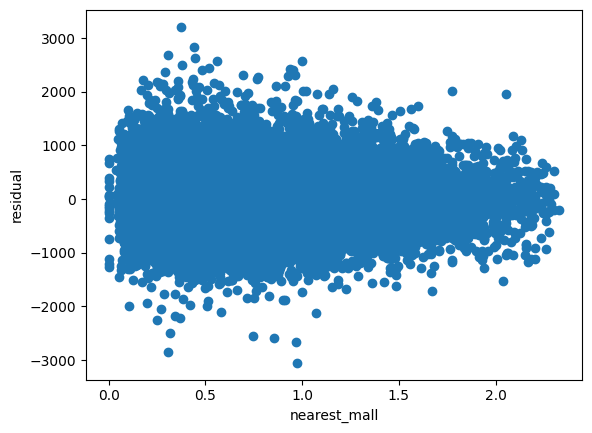

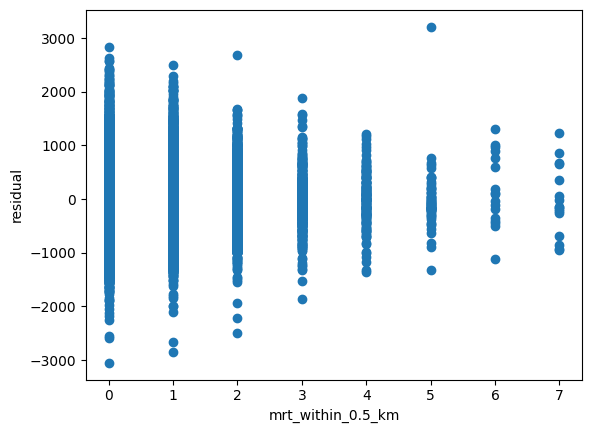

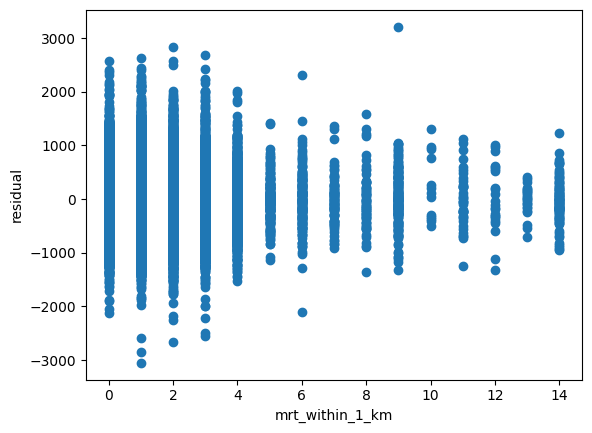

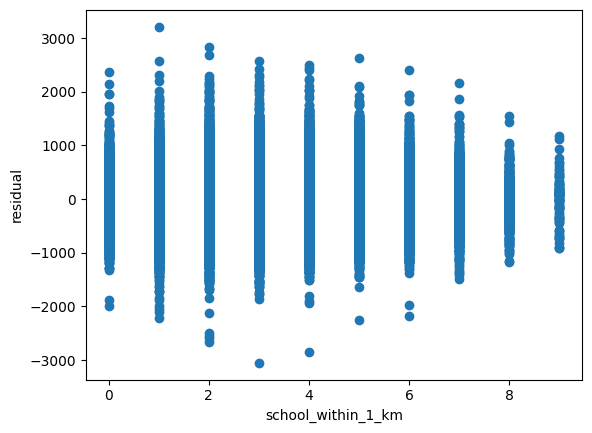

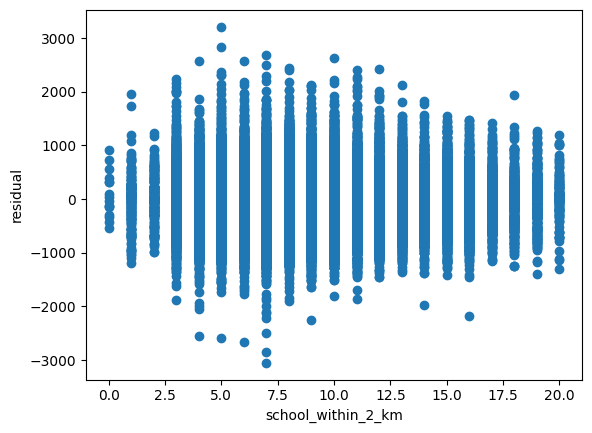

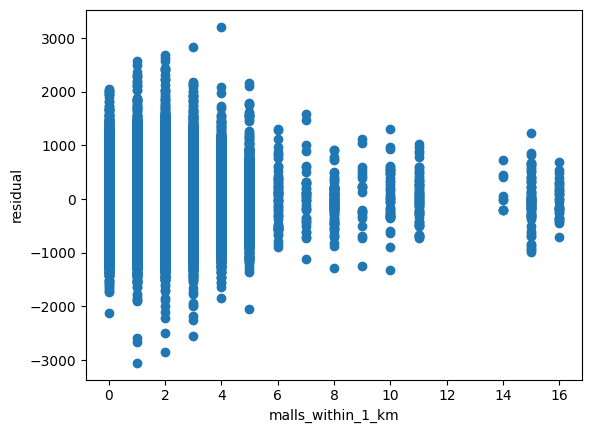

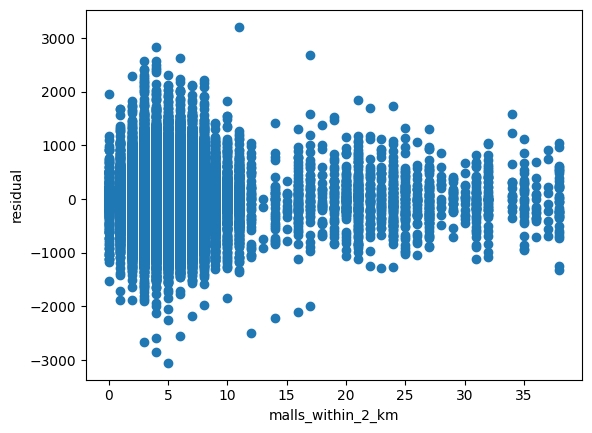

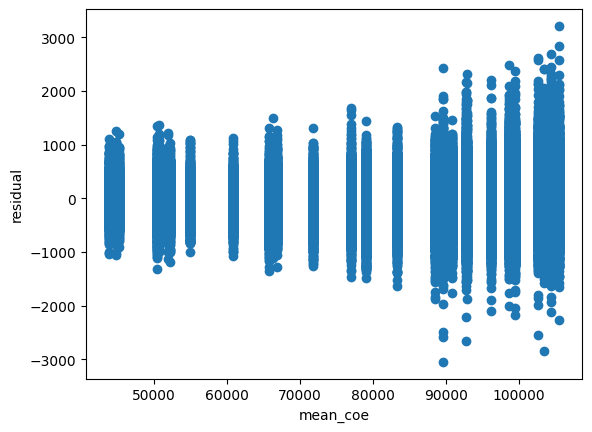

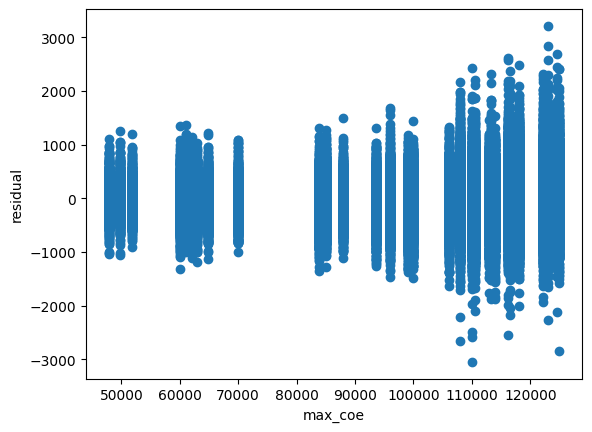

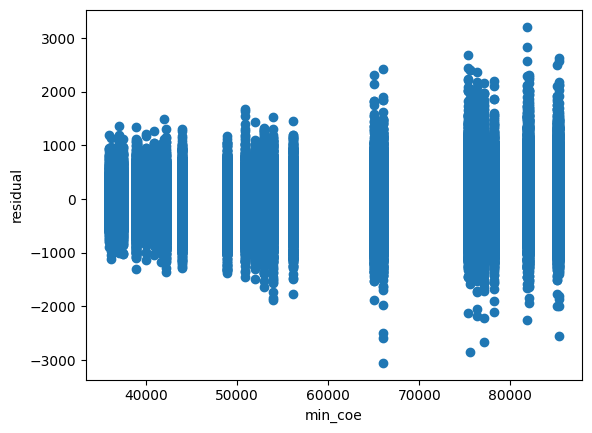

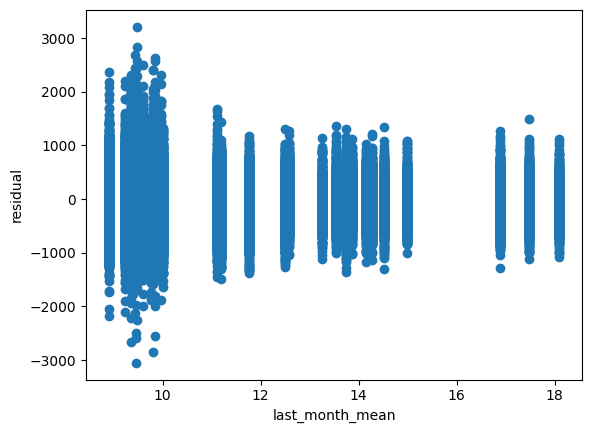

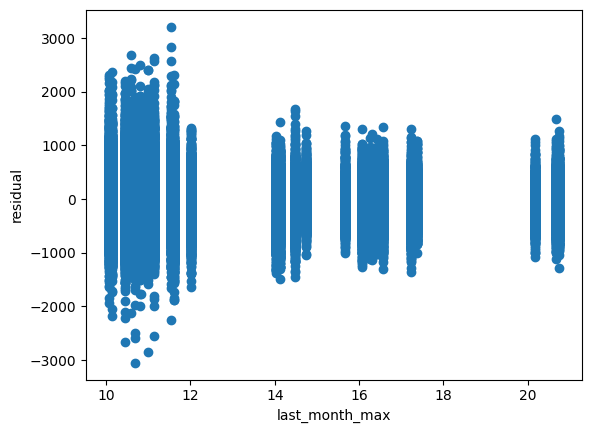

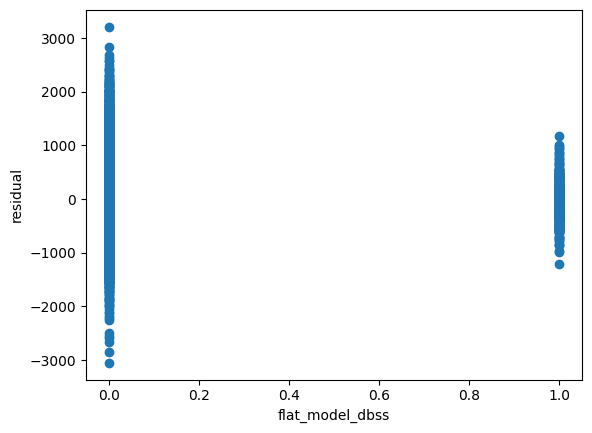

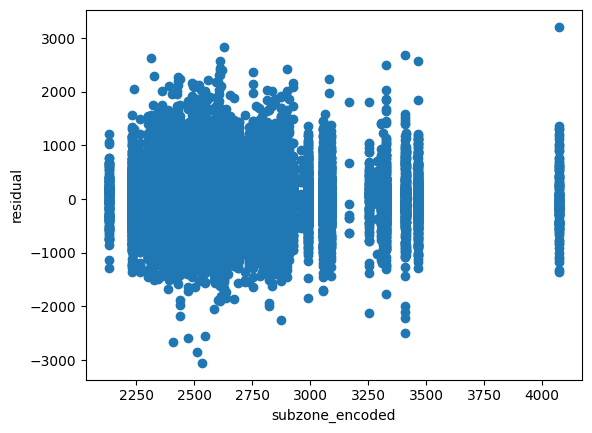

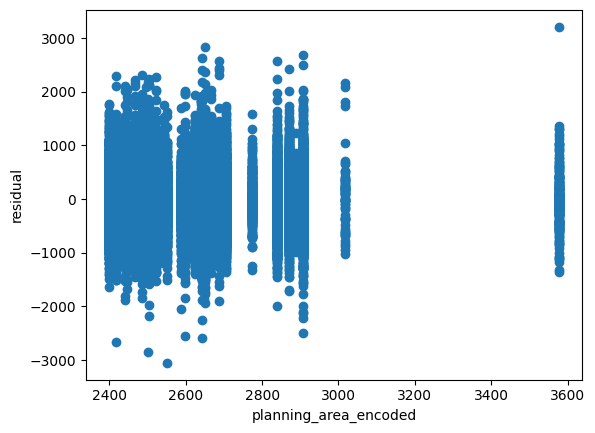

In [122]:
col_list = X_train_20.columns.tolist()
for col in col_list:
  plt.scatter(X_train_20[col],y_pred_train-y_train, label = "train")
  plt.xlabel(col)
  plt.ylabel('residual')
  plt.show()


In [123]:
important_col = X_train_20.columns.tolist()[0:6]
X_train_orig = X_train[important_col]
X_train_orig.head()

,flat_type,floor_area_sqm,nearest_mrt_exist,nearest_mrt_planned,nearest_school,nearest_mall
41147,5,121.0,0.708492,0.988849,0.159010,0.449148
18711,4,91.0,0.406746,0.422217,0.479670,0.331025
27074,3,67.0,0.998074,0.994500,0.629829,0.931079
12670,5,120.0,0.699345,1.500724,0.368022,0.428953
47874,5,115.0,1.896037,2.127675,0.298985,0.240401


In [124]:
gbm = lgb.LGBMRegressor(max_depth=5, min_child_samples=30, n_estimators=200,random_state=42, reg_lambda=0.1, num_leaves = 20)
gbm.fit(X_train_orig, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 47581, number of used features: 6
[LightGBM] [Info] Start training from score 2593.194763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMRegressor(max_depth=5, min_child_samples=30, n_estimators=200,
              num_leaves=20, random_state=42, reg_lambda=0.1)

In [125]:
from sklearn.metrics import r2_score
y_pred_train = gbm.predict(X_train_orig)
y_pred_train= (y_pred_train / 10).round() * 10
print('The r2 of train prediction is: ', r2_score(y_train,y_pred_train))
print('The rmse of train prediction is: ', round(mean_squared_error(y_train, y_pred_train) ** 0.5, 5))
y_pred_test = gbm.predict(X_test[X_train_orig.columns.tolist()], num_iteration=gbm.best_iteration_)
y_pred_test= (y_pred_test / 10).round() * 10
print('The r2 of test prediction is:', r2_score(y_test,y_pred_test) )
print('The rmse of test prediction is: ', round(mean_squared_error(y_test,y_pred_test) ** 0.5, 5))


The r2 of train prediction is:  0.23873324403038
The rmse of train prediction is:  625.05799
The r2 of test prediction is: 0.20026190435712465
The rmse of test prediction is:  635.23402
